In [2]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
%matplotlib inline

### CIFAR-100+ with/without dropout

In [46]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]


def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return outputs

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

for itype in range(2):
    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                elif itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})    
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))


0
End of epoch 01: err(train)=4.51 acc(train)=0.04
                 err(valid)=4.18 acc(valid)=0.09
End of epoch 02: err(train)=4.28 acc(train)=0.07
                 err(valid)=3.96 acc(valid)=0.13
End of epoch 03: err(train)=4.17 acc(train)=0.10
                 err(valid)=3.79 acc(valid)=0.17
End of epoch 04: err(train)=4.10 acc(train)=0.11
                 err(valid)=3.72 acc(valid)=0.19
End of epoch 05: err(train)=4.03 acc(train)=0.13
                 err(valid)=3.62 acc(valid)=0.21
End of epoch 06: err(train)=3.99 acc(train)=0.14
                 err(valid)=3.69 acc(valid)=0.21
End of epoch 07: err(train)=3.94 acc(train)=0.15
                 err(valid)=3.55 acc(valid)=0.23
End of epoch 08: err(train)=3.91 acc(train)=0.15
                 err(valid)=3.49 acc(valid)=0.23
End of epoch 09: err(train)=3.87 acc(train)=0.16
                 err(valid)=3.47 acc(valid)=0.23
End of epoch 10: err(train)=3.84 acc(train)=0.17
                 err(valid)=3.42 acc(valid)=0.25
End of epoch 11: e

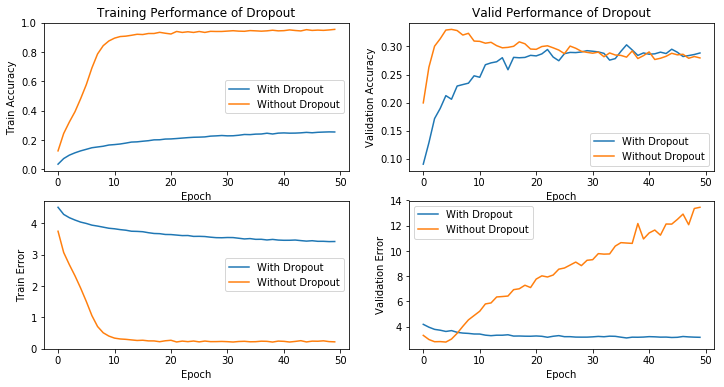

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['With Dropout', 'Without Dropout']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Dropout")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Dropout")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
fig.savefig('dropout.png')

### CIFAR-100+ different probability dropout

In [48]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]


def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return outputs

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)


with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

for itype in range(3):
    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.3})
                elif itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                elif itype == 2:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.8})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

0
End of epoch 01: err(train)=4.68 acc(train)=0.01
                 err(valid)=4.60 acc(valid)=0.01
End of epoch 02: err(train)=4.60 acc(train)=0.01
                 err(valid)=4.60 acc(valid)=0.02
End of epoch 03: err(train)=4.58 acc(train)=0.02
                 err(valid)=4.52 acc(valid)=0.03
End of epoch 04: err(train)=4.55 acc(train)=0.02
                 err(valid)=4.48 acc(valid)=0.04
End of epoch 05: err(train)=4.53 acc(train)=0.03
                 err(valid)=4.44 acc(valid)=0.04
End of epoch 06: err(train)=4.52 acc(train)=0.03
                 err(valid)=4.41 acc(valid)=0.05
End of epoch 07: err(train)=4.50 acc(train)=0.03
                 err(valid)=4.38 acc(valid)=0.05
End of epoch 08: err(train)=4.50 acc(train)=0.03
                 err(valid)=4.36 acc(valid)=0.06
End of epoch 09: err(train)=4.49 acc(train)=0.04
                 err(valid)=4.35 acc(valid)=0.06
End of epoch 10: err(train)=4.48 acc(train)=0.04
                 err(valid)=4.33 acc(valid)=0.06
End of epoch 11: e

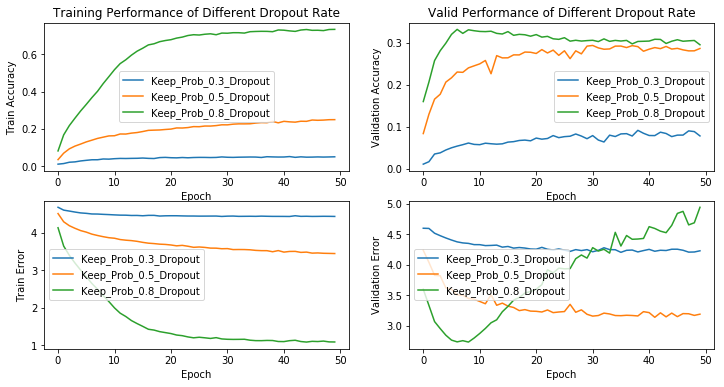

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['Keep_Prob_0.3_Dropout', 'Keep_Prob_0.5_Dropout', 'Keep_Prob_0.8_Dropout']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Different Dropout Rate")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Different Dropout Rate")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(3):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
fig.savefig('dropout_prob.png')

### CIFAR-100+ different dropout methods

In [50]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
f_prob = tf.placeholder(tf.float32)
c_prob = tf.placeholder(tf.float32)
m_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(30)]
train_err_lists = [[] for i in range(30)]
valid_acc_lists = [[] for i in range(30)]
valid_err_lists = [[] for i in range(30)]

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, f_prob)
    return outputs

def output_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = tf.nn.dropout(outputs, c_prob)
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    outputs = tf.nn.dropout(outputs, m_prob)
    return outputs
    

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)


with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)

init = tf.global_variables_initializer()
    
for itype in range(7):
    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0: #f
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:0.5, c_prob:1.0, m_prob:1.0})
                if itype == 1: #c
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:1.0, c_prob:0.5, m_prob:1.0})
                if itype == 2: #m
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:1.0, c_prob:1.0, m_prob:0.5})
                if itype == 3: #c+m
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:1.0, c_prob:0.5, m_prob:0.5})
                if itype == 4: #c+f
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:0.5, c_prob:0.5, m_prob:1.0})
                if itype == 5: #m+f
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:0.5, c_prob:1.0, m_prob:0.5})
                if itype == 6: #none
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, f_prob:1.0, c_prob:1.0, m_prob:1.0})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, f_prob:1.0, c_prob:1.0, m_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))


0
End of epoch 01: err(train)=4.50 acc(train)=0.04
                 err(valid)=4.22 acc(valid)=0.07
End of epoch 02: err(train)=4.29 acc(train)=0.07
                 err(valid)=3.94 acc(valid)=0.13
End of epoch 03: err(train)=4.19 acc(train)=0.09
                 err(valid)=3.81 acc(valid)=0.15
End of epoch 04: err(train)=4.12 acc(train)=0.11
                 err(valid)=3.76 acc(valid)=0.18
End of epoch 05: err(train)=4.05 acc(train)=0.12
                 err(valid)=3.72 acc(valid)=0.19
End of epoch 06: err(train)=4.02 acc(train)=0.13
                 err(valid)=3.63 acc(valid)=0.20
End of epoch 07: err(train)=3.98 acc(train)=0.14
                 err(valid)=3.57 acc(valid)=0.22
End of epoch 08: err(train)=3.93 acc(train)=0.15
                 err(valid)=3.52 acc(valid)=0.22
End of epoch 09: err(train)=3.89 acc(train)=0.16
                 err(valid)=3.52 acc(valid)=0.24
End of epoch 10: err(train)=3.86 acc(train)=0.16
                 err(valid)=3.53 acc(valid)=0.23
End of epoch 11: e

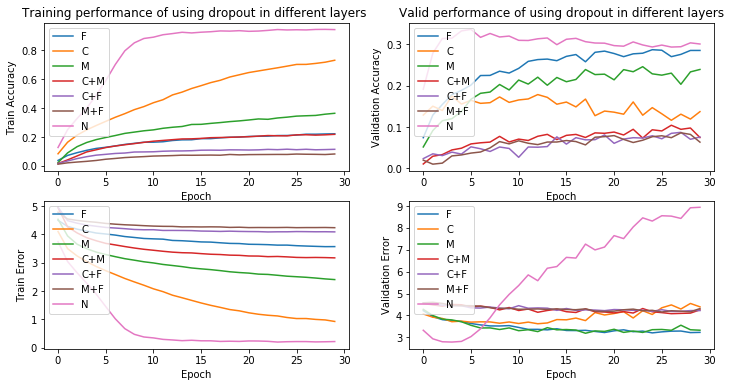

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['F', 'C', 'M','C+M','C+F','M+F','N']
x = np.arange(30) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training performance of using dropout in different layers ")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid performance of using dropout in different layers")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(7):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
fig.savefig('dropout_loc.png')

### CIFAR-100+ dropout in different dataset size

In [52]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return outputs

def output_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

for itype in range(6):
    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            count = 0
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                elif itype == 1 and count < 200:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                elif itype == 2 and count < 10:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                elif itype == 3:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                elif itype == 4 and count < 200:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                elif itype == 5 and count < 10:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                else:
                    break
                count += 1
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))


0
End of epoch 01: err(train)=4.52 acc(train)=0.03
                 err(valid)=4.28 acc(valid)=0.06
End of epoch 02: err(train)=4.33 acc(train)=0.06
                 err(valid)=4.03 acc(valid)=0.11
End of epoch 03: err(train)=4.22 acc(train)=0.09
                 err(valid)=3.87 acc(valid)=0.14
End of epoch 04: err(train)=4.15 acc(train)=0.10
                 err(valid)=3.77 acc(valid)=0.17
End of epoch 05: err(train)=4.09 acc(train)=0.11
                 err(valid)=3.69 acc(valid)=0.18
End of epoch 06: err(train)=4.05 acc(train)=0.12
                 err(valid)=3.72 acc(valid)=0.20
End of epoch 07: err(train)=4.00 acc(train)=0.13
                 err(valid)=3.59 acc(valid)=0.21
End of epoch 08: err(train)=3.97 acc(train)=0.14
                 err(valid)=3.57 acc(valid)=0.22
End of epoch 09: err(train)=3.93 acc(train)=0.15
                 err(valid)=3.54 acc(valid)=0.22
End of epoch 10: err(train)=3.88 acc(train)=0.15
                 err(valid)=3.45 acc(valid)=0.24
End of epoch 11: e

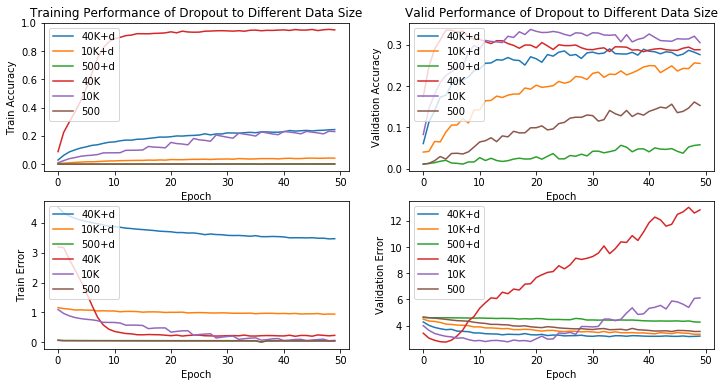

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['40K+d', '10K+d', '500+d', '40K','10K','500']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Dropout to Different Data Size")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Dropout to Different Data Size")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(6):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
fig.savefig('dropout_size.png')

### CIFAR-100+ with/without L2

In [54]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return (weights,outputs)

def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return (weights,outputs)

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1_weights, conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2_weights, conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3_weights, conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1_weights, hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2_weights, hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        hidden_3_weights, outputs  =  fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32)) 
    
for itype in range(2):  
    with tf.name_scope('error'):
        if itype == 0:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
        elif itype == 1:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets)
                   + 0.01*tf.nn.l2_loss(conv_1_weights) 
                   + 0.01*tf.nn.l2_loss(conv_2_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_1_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_2_weights) 
                   + 0.01*tf.nn.l2_loss(conv_3_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_3_weights))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)

    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            count = 0
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))


0
End of epoch 01: err(train)=3.78 acc(train)=0.12
                 err(valid)=3.35 acc(valid)=0.19
End of epoch 02: err(train)=3.09 acc(train)=0.24
                 err(valid)=3.00 acc(valid)=0.26
End of epoch 03: err(train)=2.69 acc(train)=0.32
                 err(valid)=2.80 acc(valid)=0.31
End of epoch 04: err(train)=2.33 acc(train)=0.39
                 err(valid)=2.72 acc(valid)=0.33
End of epoch 05: err(train)=1.95 acc(train)=0.47
                 err(valid)=2.74 acc(valid)=0.34
End of epoch 06: err(train)=1.53 acc(train)=0.57
                 err(valid)=3.01 acc(valid)=0.33
End of epoch 07: err(train)=1.11 acc(train)=0.68
                 err(valid)=3.31 acc(valid)=0.33
End of epoch 08: err(train)=0.73 acc(train)=0.78
                 err(valid)=3.81 acc(valid)=0.33
End of epoch 09: err(train)=0.52 acc(train)=0.84
                 err(valid)=4.48 acc(valid)=0.33
End of epoch 10: err(train)=0.42 acc(train)=0.87
                 err(valid)=4.84 acc(valid)=0.31
End of epoch 11: e

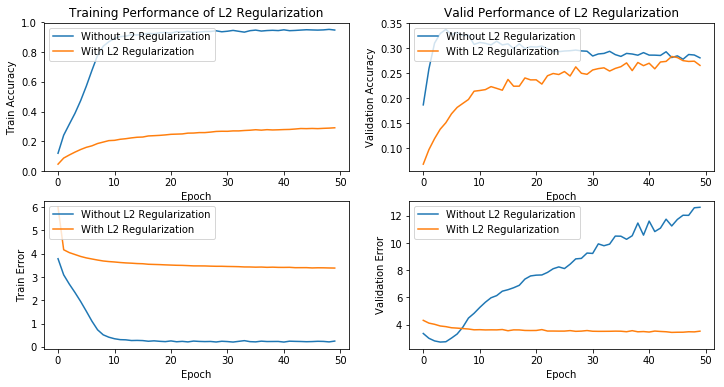

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['Without L2 Regularization', 'With L2 Regularization']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of L2 Regularization")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of L2 Regularization")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
fig.savefig('l2_regular.png')

### CIFAR-10+ L2 vs dropout

In [56]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
all_dropout = tf.placeholder(tf.float32)
flag = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists1 = [[] for i in range(50)]
train_err_lists1 = [[] for i in range(50)]
valid_acc_lists1 = [[] for i in range(50)]
valid_err_lists1 = [[] for i in range(50)]


def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return (weights,outputs)

def output_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return (weights,outputs)

def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    outputs = tf.nn.dropout(outputs, keep_prob)
    return (weights,outputs)
    

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1_weights, conv_1 = convolutional_layer(images, 5, 5, 3, 32)

    with tf.name_scope('convolutional-layer-2'):
        conv_2_weights, conv_2 = convolutional_layer(conv_1, 5, 5, 32, 64)
            
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_2, [50, 8*8*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1_weights, hidden_1 = fully_connected_layer(h_pool2_flat, 8*8*64, 1024)

    with tf.name_scope('output-layer'):
        hidden_2_weights, outputs = output_layer(hidden_1, 1024, train_data.num_classes, tf.identity)
    
for itype in range(2):
    with tf.name_scope('error'):
        if itype == 0:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
        elif itype == 1:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets)
                   + 0.01*tf.nn.l2_loss(conv_1_weights) 
                   + 0.01*tf.nn.l2_loss(conv_2_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_1_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_2_weights))

    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)

    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                if itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists1[itype].append(running_accuracy)
            train_err_lists1[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists1[itype].append(valid_accuracy)
            valid_err_lists1[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            

0
End of epoch 01: err(train)=1.93 acc(train)=0.33
                 err(valid)=1.53 acc(valid)=0.46
End of epoch 02: err(train)=1.48 acc(train)=0.46
                 err(valid)=1.36 acc(valid)=0.53
End of epoch 03: err(train)=1.35 acc(train)=0.51
                 err(valid)=1.27 acc(valid)=0.55
End of epoch 04: err(train)=1.26 acc(train)=0.55
                 err(valid)=1.16 acc(valid)=0.61
End of epoch 05: err(train)=1.20 acc(train)=0.57
                 err(valid)=1.12 acc(valid)=0.61
End of epoch 06: err(train)=1.14 acc(train)=0.59
                 err(valid)=1.03 acc(valid)=0.64
End of epoch 07: err(train)=1.08 acc(train)=0.62
                 err(valid)=1.02 acc(valid)=0.64
End of epoch 08: err(train)=1.05 acc(train)=0.63
                 err(valid)=0.97 acc(valid)=0.67
End of epoch 09: err(train)=1.01 acc(train)=0.64
                 err(valid)=0.98 acc(valid)=0.66
End of epoch 10: err(train)=0.98 acc(train)=0.65
                 err(valid)=0.93 acc(valid)=0.68
End of epoch 11: e

In [57]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
all_dropout = tf.placeholder(tf.float32)
flag = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists2 = [[] for i in range(50)]
train_err_lists2 = [[] for i in range(50)]
valid_acc_lists2 = [[] for i in range(50)]
valid_err_lists2 = [[] for i in range(50)]



def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return (weights,outputs)

def output_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return (weights,outputs)


with tf.name_scope('structure'):   
    with tf.name_scope('fc-layer-1'):
        hidden_1_weights, hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], 1024)

    with tf.name_scope('output-layer'):
        hidden_2_weights, outputs = output_layer(hidden_1, 1024, train_data.num_classes, tf.identity)
    
for itype in range(2):
    with tf.name_scope('error'):
        if itype == 0:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
        elif itype == 1:
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets)
                   + 0.01*tf.nn.l2_loss(hidden_1_weights) 
                   + 0.01*tf.nn.l2_loss(hidden_2_weights))

    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)

    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                if itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists2[itype].append(running_accuracy)
            train_err_lists2[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists2[itype].append(valid_accuracy)
            valid_err_lists2[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            

0
End of epoch 01: err(train)=2.13 acc(train)=0.23
                 err(valid)=1.91 acc(valid)=0.31
End of epoch 02: err(train)=1.99 acc(train)=0.26
                 err(valid)=1.86 acc(valid)=0.33
End of epoch 03: err(train)=1.96 acc(train)=0.27
                 err(valid)=1.84 acc(valid)=0.34
End of epoch 04: err(train)=1.94 acc(train)=0.28
                 err(valid)=1.84 acc(valid)=0.33
End of epoch 05: err(train)=1.93 acc(train)=0.29
                 err(valid)=1.82 acc(valid)=0.35
End of epoch 06: err(train)=1.92 acc(train)=0.29
                 err(valid)=1.80 acc(valid)=0.37
End of epoch 07: err(train)=1.90 acc(train)=0.29
                 err(valid)=1.78 acc(valid)=0.36
End of epoch 08: err(train)=1.90 acc(train)=0.30
                 err(valid)=1.76 acc(valid)=0.37
End of epoch 09: err(train)=1.89 acc(train)=0.31
                 err(valid)=1.75 acc(valid)=0.39
End of epoch 10: err(train)=1.89 acc(train)=0.31
                 err(valid)=1.77 acc(valid)=0.38
End of epoch 11: e

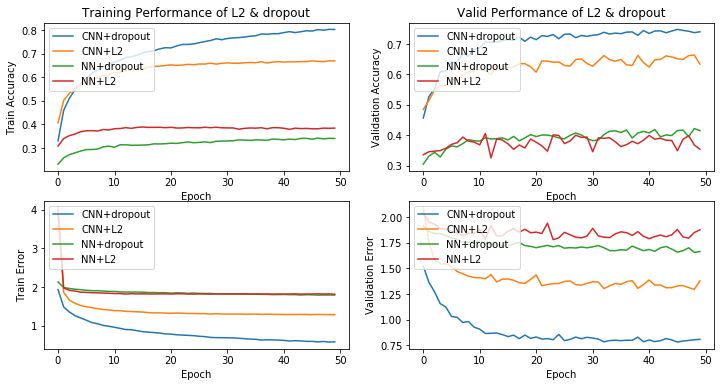

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['CNN+dropout','CNN+L2','NN+dropout', 'NN+L2']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of L2 & dropout")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of L2 & dropout")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists1[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists1[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists1[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists1[layer_num],label=line_name[layer_num]) 
for layer_num in range(2):
    ax1.plot(x,train_acc_lists2[layer_num],label=line_name[layer_num+2]) 
    ax2.plot(x,valid_acc_lists2[layer_num],label=line_name[layer_num+2]) 
    ax3.plot(x,train_err_lists2[layer_num],label=line_name[layer_num+2]) 
    ax4.plot(x,valid_err_lists2[layer_num],label=line_name[layer_num+2])
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
fig.savefig('l2_dropout.png')

### CIFAR-100+ data augmentation

In [59]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)
# define placeholder for inputs to network
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
condition = tf.placeholder(tf.int32, shape=[], name="condition")


train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]

def data_augmentation(image):
    image = tf.cond(condition > 0, lambda:pre_process_image(image) , lambda: reshape_image(image))
    return image

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

def pre_process_image(image):
    image = reshape_image(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    # Some of these functions may overflow and result in pixel
    # values beyond the [0, 1] range. It is unclear from the
    # documentation of TensorFlow 0.10.0rc0 whether this is
    # intended. A simple solution is to limit the range.

    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    return image


def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    # stride [1, x_movement, y_movement, 1]
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim, is_bn = 1):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, keep_prob=0.8, is_dropout = 0, is_nb = 0):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs



with tf.name_scope('structure'):
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: data_augmentation(image), inputs)
    
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
        
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [50, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)
        
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9).minimize(error)

saver = tf.train.Saver()
# important step
init = tf.global_variables_initializer()

for itype in range(2):
    with tf.Session() as sess:
        sess.run(init)
        for i in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 1})
                elif itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 0})
                
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(i + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, condition: 0})
                valid_error += batch_error
                valid_accuracy += batch_acc

            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=4.39 acc(train)=0.04
                 err(valid)=4.04 acc(valid)=0.09
End of epoch 02: err(train)=4.01 acc(train)=0.09
                 err(valid)=3.76 acc(valid)=0.14
End of epoch 03: err(train)=3.81 acc(train)=0.13
                 err(valid)=3.62 acc(valid)=0.16
End of epoch 04: err(train)=3.69 acc(train)=0.15
                 err(valid)=3.48 acc(valid)=0.19
End of epoch 05: err(train)=3.57 acc(train)=0.17
                 err(valid)=3.43 acc(valid)=0.20
End of epoch 06: err(train)=3.47 acc(train)=0.19
                 err(valid)=3.33 acc(valid)=0.21
End of epoch 07: err(train)=3.37 acc(train)=0.21
                 err(valid)=3.26 acc(valid)=0.23
End of epoch 08: err(train)=3.27 acc(train)=0.22
                 err(valid)=3.20 acc(valid)=0.24
End of epoch 09: err(train)=3.19 acc(train)=0.24
                 err(valid)=3.20 acc(valid)=0.24
End of epoch 10: err(train)=3.11 acc(train)=0.25
                 err(valid)=3.08 acc(valid)=0.27
End of epoch 11: err

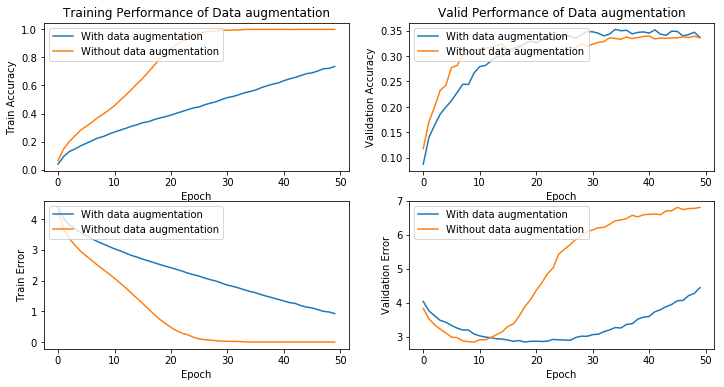

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['With data augmentation', 'Without data augmentation']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Data augmentation")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Data augmentation")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
fig.savefig('data_aug_100.png')

### CIFAR-10+ data augmentation

In [61]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)
# define placeholder for inputs to network
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
condition = tf.placeholder(tf.int32, shape=[], name="condition")


train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]

def data_augmentation(image):
    image = tf.cond(condition > 0, lambda:pre_process_image(image) , lambda: reshape_image(image))
    return image

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

def pre_process_image(image):
    image = reshape_image(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    # Some of these functions may overflow and result in pixel
    # values beyond the [0, 1] range. It is unclear from the
    # documentation of TensorFlow 0.10.0rc0 whether this is
    # intended. A simple solution is to limit the range.

    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    return image


def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    # stride [1, x_movement, y_movement, 1]
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim, is_bn = 1):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, keep_prob=0.8, is_dropout = 0, is_nb = 0):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs



with tf.name_scope('structure'):
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: data_augmentation(image), inputs)
    
    with tf.name_scope('convolutional-layer-1'):
        conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
        
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [50, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)
        
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9).minimize(error)

saver = tf.train.Saver()
# important step
init = tf.global_variables_initializer()

for itype in range(2):
    with tf.Session() as sess:
        sess.run(init)
        for i in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 1})
                elif itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 0})
                
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(i + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, condition: 0})
                valid_error += batch_error
                valid_accuracy += batch_acc

            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=1.93 acc(train)=0.30
                 err(valid)=1.67 acc(valid)=0.40
End of epoch 02: err(train)=1.66 acc(train)=0.40
                 err(valid)=1.52 acc(valid)=0.46
End of epoch 03: err(train)=1.54 acc(train)=0.45
                 err(valid)=1.41 acc(valid)=0.50
End of epoch 04: err(train)=1.46 acc(train)=0.48
                 err(valid)=1.42 acc(valid)=0.50
End of epoch 05: err(train)=1.39 acc(train)=0.51
                 err(valid)=1.28 acc(valid)=0.55
End of epoch 06: err(train)=1.32 acc(train)=0.54
                 err(valid)=1.27 acc(valid)=0.56
End of epoch 07: err(train)=1.28 acc(train)=0.55
                 err(valid)=1.24 acc(valid)=0.58
End of epoch 08: err(train)=1.23 acc(train)=0.57
                 err(valid)=1.24 acc(valid)=0.57
End of epoch 09: err(train)=1.18 acc(train)=0.59
                 err(valid)=1.21 acc(valid)=0.59
End of epoch 10: err(train)=1.14 acc(train)=0.60
                 err(valid)=1.14 acc(valid)=0.61
End of epoch 11: err

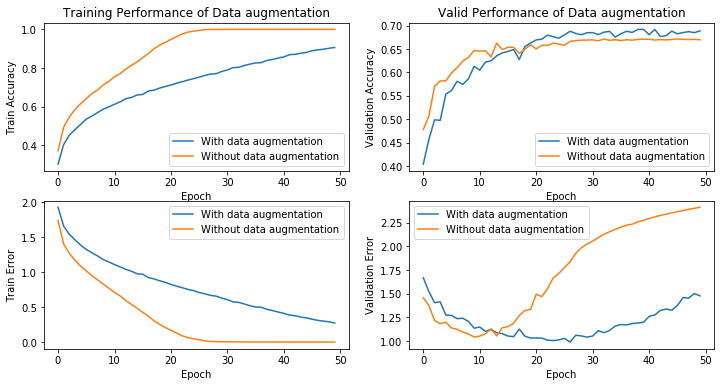

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['With data augmentation', 'Without data augmentation']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Data augmentation")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Data augmentation")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
fig.savefig('data_aug.png')

### CIFAR-10+ different data augmentation methods

In [63]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

# define placeholder for inputs to network
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
condition = tf.placeholder(tf.int32, shape=[], name="condition")

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]


def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    # stride [1, x_movement, y_movement, 1]
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim, is_bn = 1):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, keep_prob=0.8, is_dropout = 0, is_nb = 0):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs


for itype in range(2):
    
    def data_augmentation(image):
        image = tf.cond(condition > 0, lambda:pre_process_image(image) , lambda: reshape_image(image))
        return image

    def reshape_image(image):
        image = tf.reshape(image, [3,32,32])
        image = tf.transpose(image, [1, 2, 0])
        return image

    def pre_process_image(image):
        image = reshape_image(image)
        if itype == 0:
            image = tf.image.random_brightness(image, max_delta=0.5)
        elif itype == 1:
            image = tf.image.random_flip_left_right(image)
        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
        return image
    
    with tf.name_scope('structure'):
        with tf.name_scope('pre_process'):
            images = tf.map_fn(lambda image: data_augmentation(image), inputs)

        with tf.name_scope('convolutional-layer-1'):
            conv_1 = convolutional_layer(images, 5, 5, 3, 16)

        with tf.name_scope('convolutional-layer-2'):
            conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)

        with tf.name_scope('convolutional-layer-3'):
            conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)

        with tf.name_scope('3D-to-1D'):
            h_pool2_flat = tf.reshape(conv_3, [50, 4*4*64])

        with tf.name_scope('fc-layer-1'):
            hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)

        with tf.name_scope('fc-layer-2'):
            hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

        with tf.name_scope('output-layer'):
            outputs = fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))

    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9).minimize(error)

    saver = tf.train.Saver()
    # important step
    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        for i in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                if itype == 0:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 1})
                elif itype == 1:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch, condition: 1})
            
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(i + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, condition: 0})
                valid_error += batch_error
                valid_accuracy += batch_acc

            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))

End of epoch 01: err(train)=1.85 acc(train)=0.34
                 err(valid)=1.61 acc(valid)=0.42
End of epoch 02: err(train)=1.55 acc(train)=0.44
                 err(valid)=1.44 acc(valid)=0.49
End of epoch 03: err(train)=1.44 acc(train)=0.48
                 err(valid)=1.34 acc(valid)=0.53
End of epoch 04: err(train)=1.35 acc(train)=0.52
                 err(valid)=1.27 acc(valid)=0.55
End of epoch 05: err(train)=1.28 acc(train)=0.55
                 err(valid)=1.23 acc(valid)=0.57
End of epoch 06: err(train)=1.22 acc(train)=0.57
                 err(valid)=1.19 acc(valid)=0.58
End of epoch 07: err(train)=1.15 acc(train)=0.59
                 err(valid)=1.15 acc(valid)=0.60
End of epoch 08: err(train)=1.10 acc(train)=0.61
                 err(valid)=1.14 acc(valid)=0.60
End of epoch 09: err(train)=1.05 acc(train)=0.63
                 err(valid)=1.12 acc(valid)=0.61
End of epoch 10: err(train)=1.01 acc(train)=0.65
                 err(valid)=1.08 acc(valid)=0.63
End of epoch 11: err

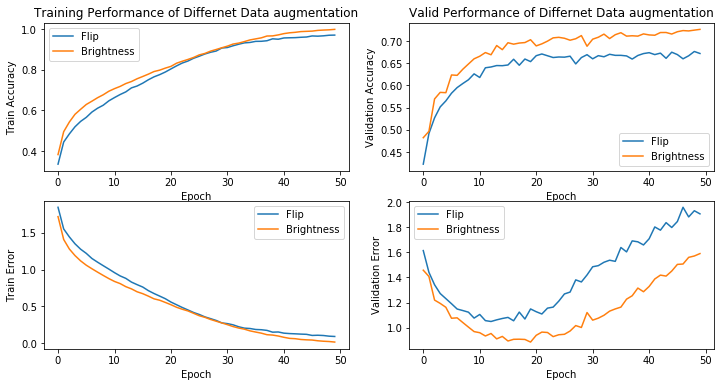

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['Flip', 'Brightness']
x = np.arange(50) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Differnet Data augmentation")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Differnet Data augmentation")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
fig.savefig('flip_brightness.png')

### CIFAR-100+ early stopping

In [ ]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob = tf.placeholder(tf.float32)
num_hidden = 200

train_acc_lists = [[] for i in range(50)]
train_err_lists = [[] for i in range(50)]
valid_acc_lists = [[] for i in range(50)]
valid_err_lists = [[] for i in range(50)]

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    outputs = tf.nn.dropout(outputs, keep_prob)
    return outputs

def weight_variable(shape):
    with tf.name_scope('weight'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

def conv2d(inputs, Weights, biases):
    linout = tf.nn.conv2d(inputs, Weights, 
              strides=[1, 1, 1, 1], padding='SAME') + biases  
    outputs = tf.nn.relu(linout)
    return outputs

def max_pool_2x2(inputs):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(inputs, patch_x, patch_y, input_dim, output_dim):
    weights = weight_variable([patch_x, patch_y, input_dim, output_dim]) # patch 5x5, in size 1, out size 32
    biases  = bias_variable([output_dim])
    conv    = conv2d(inputs, weights, biases)
    outputs = tf.nn.relu(conv) # output size 32x32x32
    outputs = max_pool_2x2(outputs)          # output size 16x16x32
    return outputs
    

def reshape_image(image):
    image = tf.reshape(image, [3,32,32])
    image = tf.transpose(image, [1, 2, 0])
    return image

with tf.name_scope('structure'): 
    with tf.name_scope('pre_process'):
        images = tf.map_fn(lambda image: reshape_image(image), inputs)
        
    with tf.name_scope('convolutional-layer-1'):
        conv_1_weights, conv_1 = convolutional_layer(images, 5, 5, 3, 16)

    with tf.name_scope('convolutional-layer-2'):
        conv_2_weights, conv_2 = convolutional_layer(conv_1, 5, 5, 16, 32)
        
    with tf.name_scope('convolutional-layer-3'):
        conv_3_weights, conv_3 = convolutional_layer(conv_2, 5, 5, 32, 64)
    
    with tf.name_scope('3D-to-1D'):
        h_pool2_flat = tf.reshape(conv_3, [-1, 4*4*64])

    with tf.name_scope('fc-layer-1'):
        hidden_1_weights, hidden_1 = fully_connected_layer(h_pool2_flat, 4*4*64, 1024)
        
    with tf.name_scope('fc-layer-2'):
        hidden_2_weights, hidden_2 = fully_connected_layer(hidden_1, 1024, 1024)

    with tf.name_scope('output-layer'):
        hidden_3_weights, outputs  =  fully_connected_layer(hidden_2, 1024, train_data.num_classes, tf.identity)
    

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=targets))
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

for itype in range(2):
    with tf.Session() as sess:
        sess.run(init)
        print(itype)
        max_acc = 0
        count = 0
        for e in range(1):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 0.5})
                running_error += batch_error
                running_accuracy += batch_acc

            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            train_acc_lists[itype].append(running_accuracy)
            train_err_lists[itype].append(running_error)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            if valid_accuracy > max_acc:
                max_acc = valid_accuracy
                count = 0
            else:
                count += 1
            if count == 10 and itype == 0:
                break
            valid_acc_lists[itype].append(valid_accuracy)
            valid_err_lists[itype].append(valid_error)
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

line_name = ['With Early Stopping', 'Without Early Stopping']
x = np.arange(1) 

# plot train accuracy
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# Sets x-axis
ax1.set_xlabel('Epoch')
# Sets y-axis
ax1.set_ylabel('Train Accuracy')
# Sets title
ax1.set_title("Training Performance of Early Stopping")
ax2.set_xlabel('Epoch')
# Sets y-axis
ax2.set_ylabel('Validation Accuracy')
# Sets title
ax2.set_title("Valid Performance of Early Stopping")
ax3.set_xlabel('Epoch')
# Sets y-axis
ax3.set_ylabel('Train Error')
# Sets title
ax4.set_xlabel('Epoch')
# Sets y-axis
ax4.set_ylabel('Validation Error')


for layer_num in range(2):
    ax1.plot(x,train_acc_lists[layer_num],label=line_name[layer_num]) 
    ax2.plot(x,valid_acc_lists[layer_num],label=line_name[layer_num]) 
    ax3.plot(x,train_err_lists[layer_num],label=line_name[layer_num]) 
    ax4.plot(x,valid_err_lists[layer_num],label=line_name[layer_num]) 
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
fig.savefig('early_stopping.png')